## Imports

In [145]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

from sklearn.decomposition import FastICA

import warnings
warnings.filterwarnings("ignore")

### Loading the data

In [95]:
def load_word_vectors(file):
    word_vectors = {}
    with open(file, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            word_vectors[word] = vector
    return word_vectors

In [96]:
word_vectors = load_word_vectors('data/nmt-en-dec-512.txt')
words = np.asarray(list(word_vectors.keys()))
vectors = np.asarray(list(word_vectors.values()), dtype=np.float64)
print(len(word_vectors['the']))
print(words.shape, vectors.shape)

512
(5000,) (5000, 512)


## Task 1

In [97]:
def visualize_TSNE(vectors, words, n_labels=80):
    tsne = TSNE(n_components=2, random_state=0)
    Y = tsne.fit_transform(vectors)
    plt.figure(figsize=(10, 10))
    plt.scatter(Y[:, 0], Y[:, 1])

    permutations = np.random.permutation(len(words))
    for i in permutations[:n_labels]:
        plt.annotate(words[i], xy=(Y[i, 0], Y[i, 1]), xytext=(0, 0), textcoords='offset points')

    plt.show()

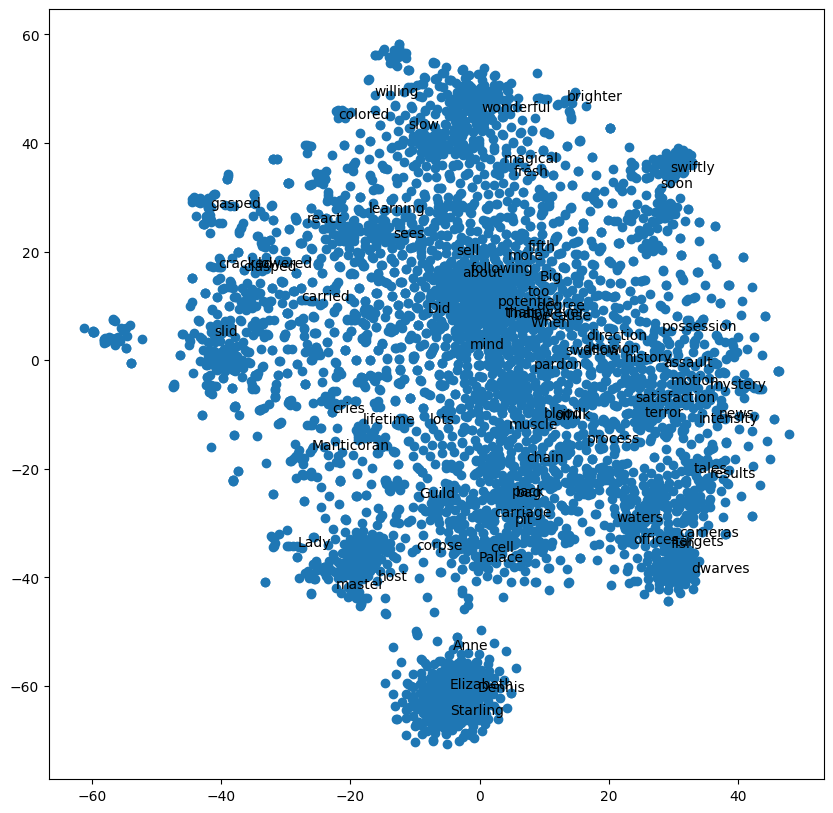

In [98]:
visualize_TSNE(vectors, words)

We can clearly see a cluster of names at the bottom.

## Task 2

In [99]:
def clusters_kmeans(vectors, n_clusters=[3,5,10]):
    silhouette_scores = []
    clusters = []
    for n in n_clusters:
        kmeans = KMeans(n_clusters=n, random_state=0)
        labels = kmeans.fit_predict(vectors)
        labels = np.asarray(labels)
        clusters.append(labels)
        #print(labels)
        silhouette_scores.append(silhouette_score(vectors, labels))
    return clusters, silhouette_scores

def clusters_gaussian(vectors, n_clusters=[3,5,10]):
    silhouette_scores = []
    clusters = []
    for n in n_clusters:
        gaussian = GaussianMixture(n_components=n, random_state=0)
        labels = gaussian.fit_predict(vectors)
        clusters.append(labels)
        silhouette_scores.append(silhouette_score(vectors, labels))
    return clusters, silhouette_scores

def clusters_agglomerative(vectors, n_clusters=[3,5,10], linkage=['ward', 'single', 'complete']):
    silhouette_scores = []
    clusters = []
    for n in n_clusters:
        for l in linkage:
            agglomerative = AgglomerativeClustering(n_clusters=n, linkage=l)
            labels = agglomerative.fit_predict(vectors)
            clusters.append(labels)
            silhouette_scores.append(silhouette_score(vectors, labels))
            #print(silhouette_scores)
    return clusters, silhouette_scores
    
#plot the clusters using different colors in T-SNE
def plot_clusters(axs, Y, words, clusters, n_labels=50, title = ''):
    axs.scatter(Y[:, 0], Y[:, 1], c=clusters)
    axs.set_title(title)
    permutations = np.random.permutation(len(words))
    for i in permutations[:n_labels]:
        axs.annotate(words[i], xy=(Y[i, 0], Y[i, 1]), xytext=(0, 0), textcoords='offset points')

In [113]:
#compare the silhouette scores of different clustering algorithms
def compare_silhouette_scores(vectors, n_clusters=[3,5,10], linkage = ['ward', 'single', 'complete'], t_sne = True, plot_clusters = True):
    kmeans_clusters, kmeans_scores = clusters_kmeans(vectors, n_clusters)
    gaussian_clusters, gaussian_scores = clusters_gaussian(vectors, n_clusters)
    agglomerative_clusters, agglomerative_scores = clusters_agglomerative(vectors, n_clusters, linkage)
    fig, axs = plt.subplots(1, 2, figsize=(20,10))
    #print([agglomerative_scores[i] for i in [j*len(linkage) for j in range(len(n_clusters))]])
    axs[0].plot(n_clusters, kmeans_scores, label='KMeans')
    axs[0].plot(n_clusters, gaussian_scores, label='Gaussian')
    axs[0].plot(n_clusters, [agglomerative_scores[i] for i in [j*len(linkage) for j in range(len(n_clusters))]], label='Agglomerative {}'.format(linkage[0]))
    axs[0].set_title('Kmeans, Gaussian and Agglomerative Ward')
    axs[0].legend()
    axs[1].plot(n_clusters, [agglomerative_scores[i] for i in [j*len(linkage)+1 for j in range(len(n_clusters))]], label='Agglomerative {}'.format(linkage[1]))
    axs[1].plot(n_clusters, [agglomerative_scores[i] for i in [j*len(linkage)+2 for j in range(len(n_clusters))]], label='Agglomerative {}'.format(linkage[2]))
    axs[1].set_title('Agglomerative Single and Complete')
    axs[1].legend()
    plt.show()
    plt.close()

    #plot all the clusters side a side for each category
    if plot_clusters:
        fig, axs = plt.subplots(2 + len(linkage), len(n_clusters), figsize=(20, 20))
        if t_sne:
            tsne = TSNE(n_components=2, random_state=0)
            Y = tsne.fit_transform(vectors)
        else:
            Y = vectors
        for i in range(len(n_clusters)):
            plot_clusters(axs[0, i], Y, words, kmeans_clusters[i], title='KMeans {}'.format(n_clusters[i]))
            plot_clusters(axs[1, i], Y, words, gaussian_clusters[i], title='Gaussian {}'.format(n_clusters[i]))
            for j in range(len(linkage)):
                plot_clusters(axs[j+2, i], Y, words, agglomerative_clusters[i*len(linkage)+j], title='Agglomerative {} {}'.format(linkage[j], n_clusters[i]))
        plt.show()
        plt.close()


[0.023808241547960473, 0.02542531390886626, 0.011651580565028645]


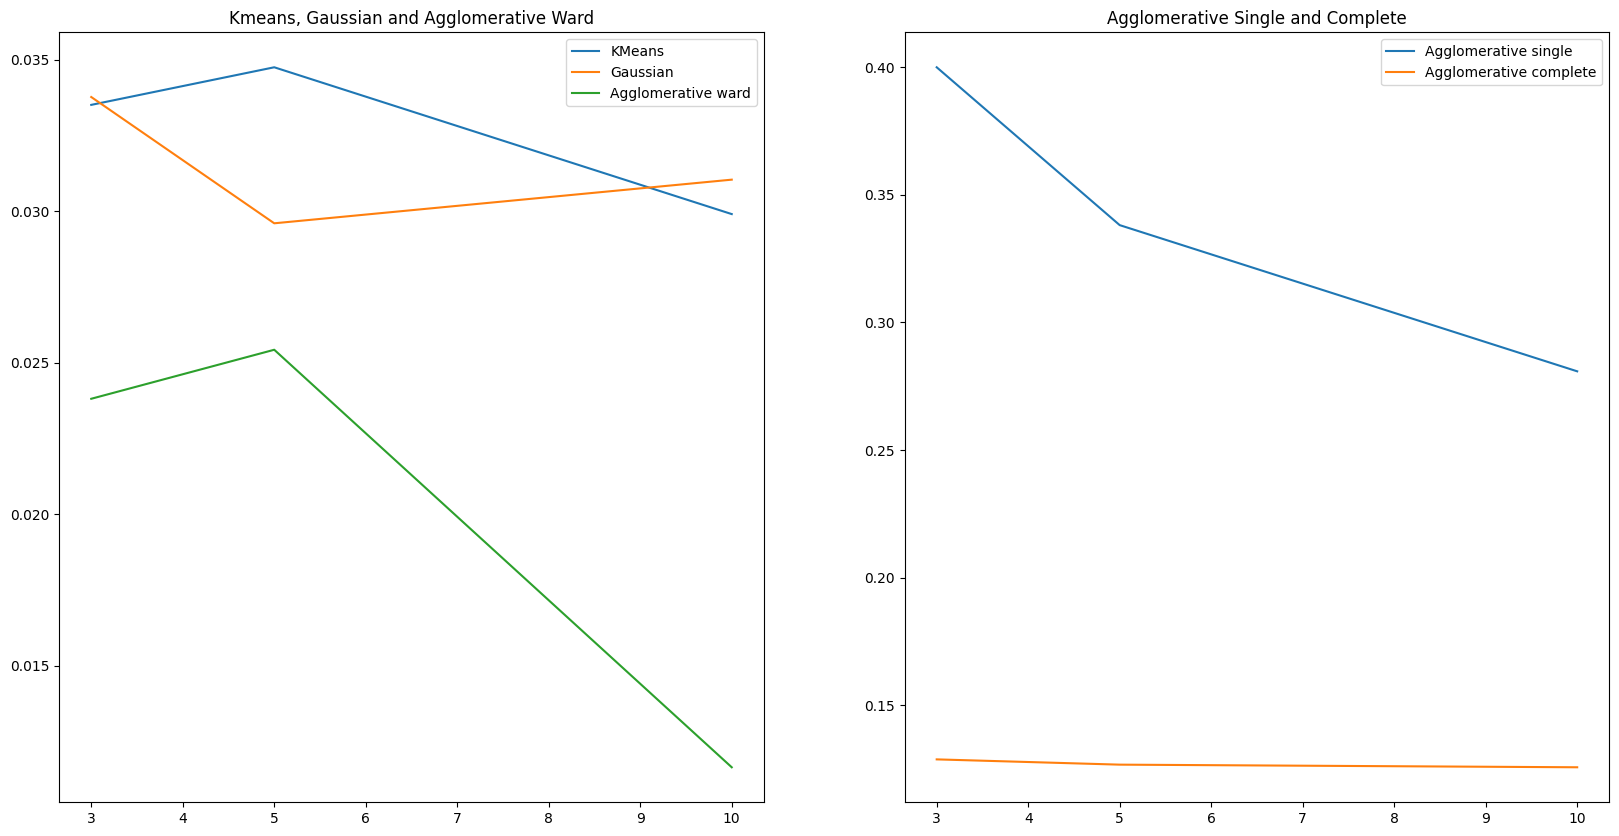

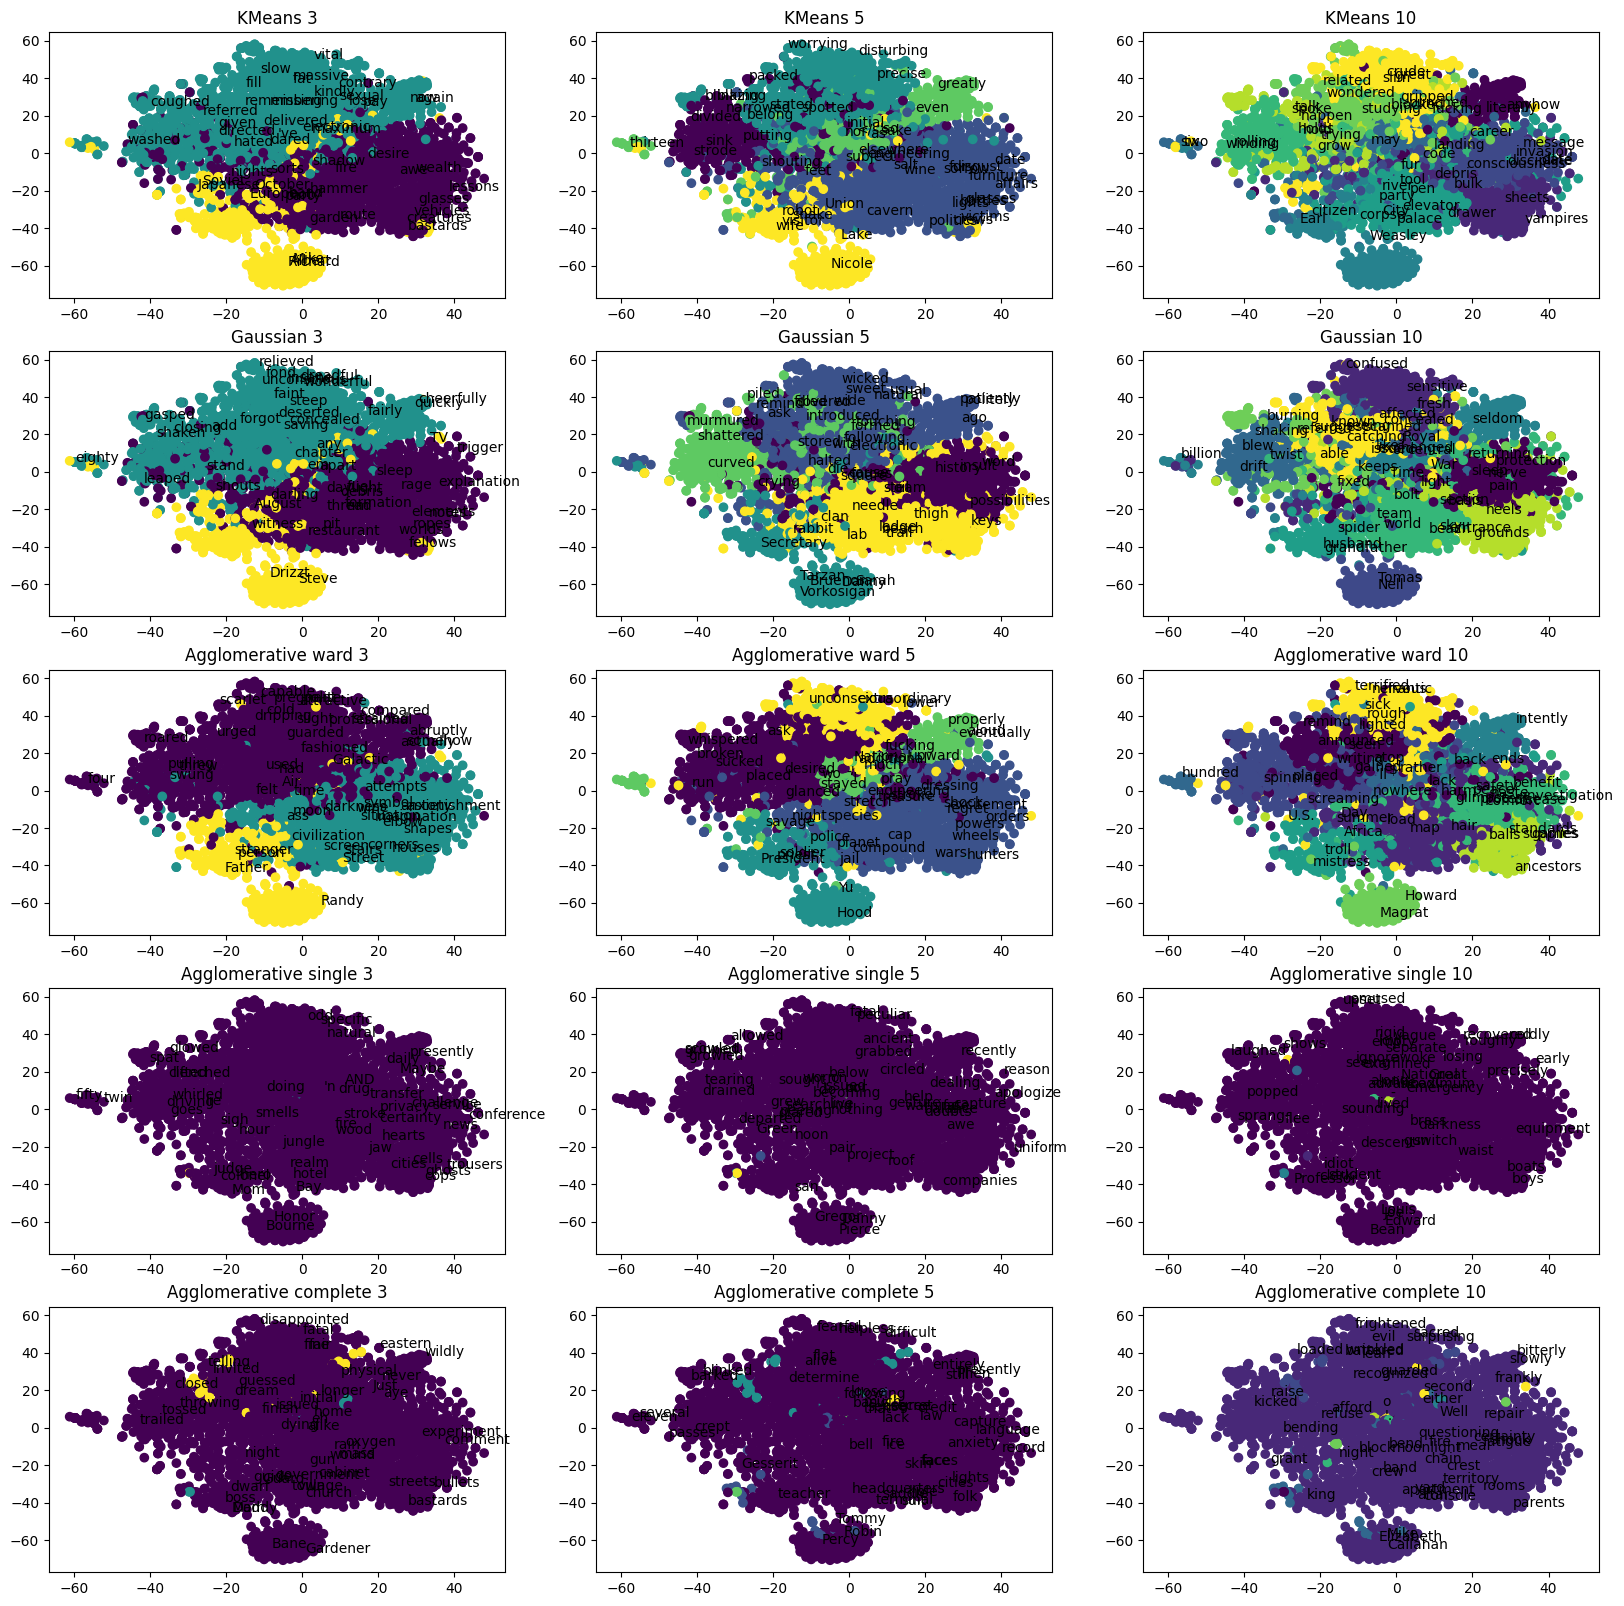

In [103]:
compare_silhouette_scores(vectors)

The best method according to the silhouette score would be the KMeans for 5 clusters and the ones that failed are the Agglomerative clustering using single & complete linkages.

## Task 3

In [115]:
def visualize_PCA(vectors, words, n_components = 2, n_labels=80):
    pca = PCA(n_components=n_components, random_state=0)
    Y = pca.fit_transform(vectors)
    plt.figure(figsize=(10, 10))
    plt.scatter(Y[:, 0], Y[:, 1])

    permutations = np.random.permutation(len(words))
    for i in permutations[:n_labels]:
        plt.annotate(words[i], xy=(Y[i, 0], Y[i, 1]), xytext=(0, 0), textcoords='offset points')

    plt.show()

    return Y


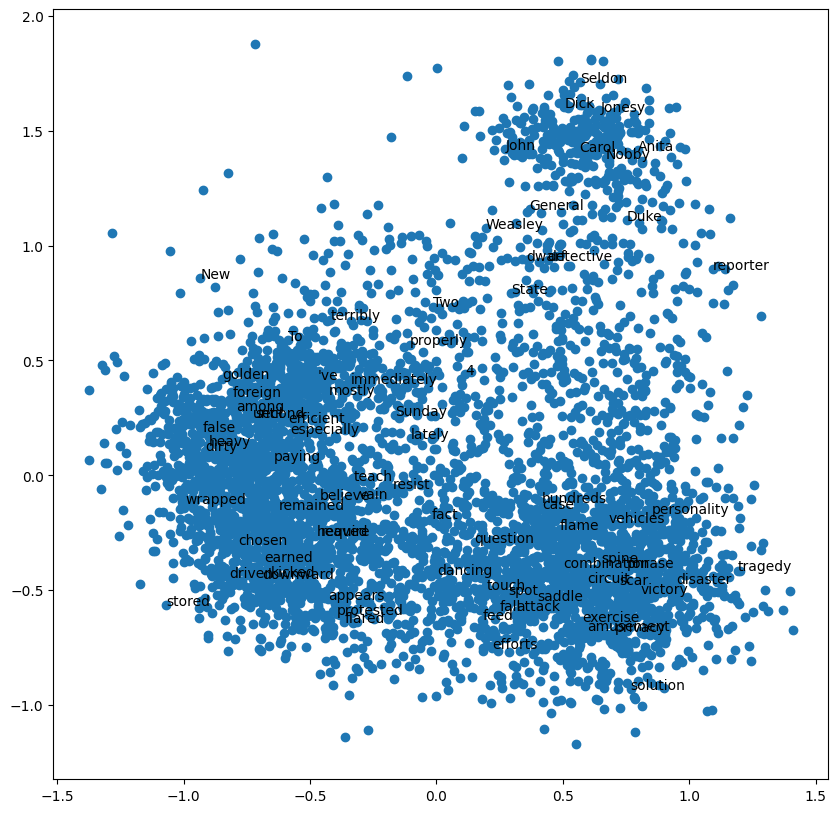

In [116]:
Y_pca = visualize_PCA(vectors, words)

On the x-axis we could think the feature represented is according to the 'class' of the words (on the right we can see the commons word and on the left the verbs/adjectives). On the y-axis we can still see the names cluster, and then I'd say the feature is the more up you are the more you are a human-related word and the more down you are the less it is.

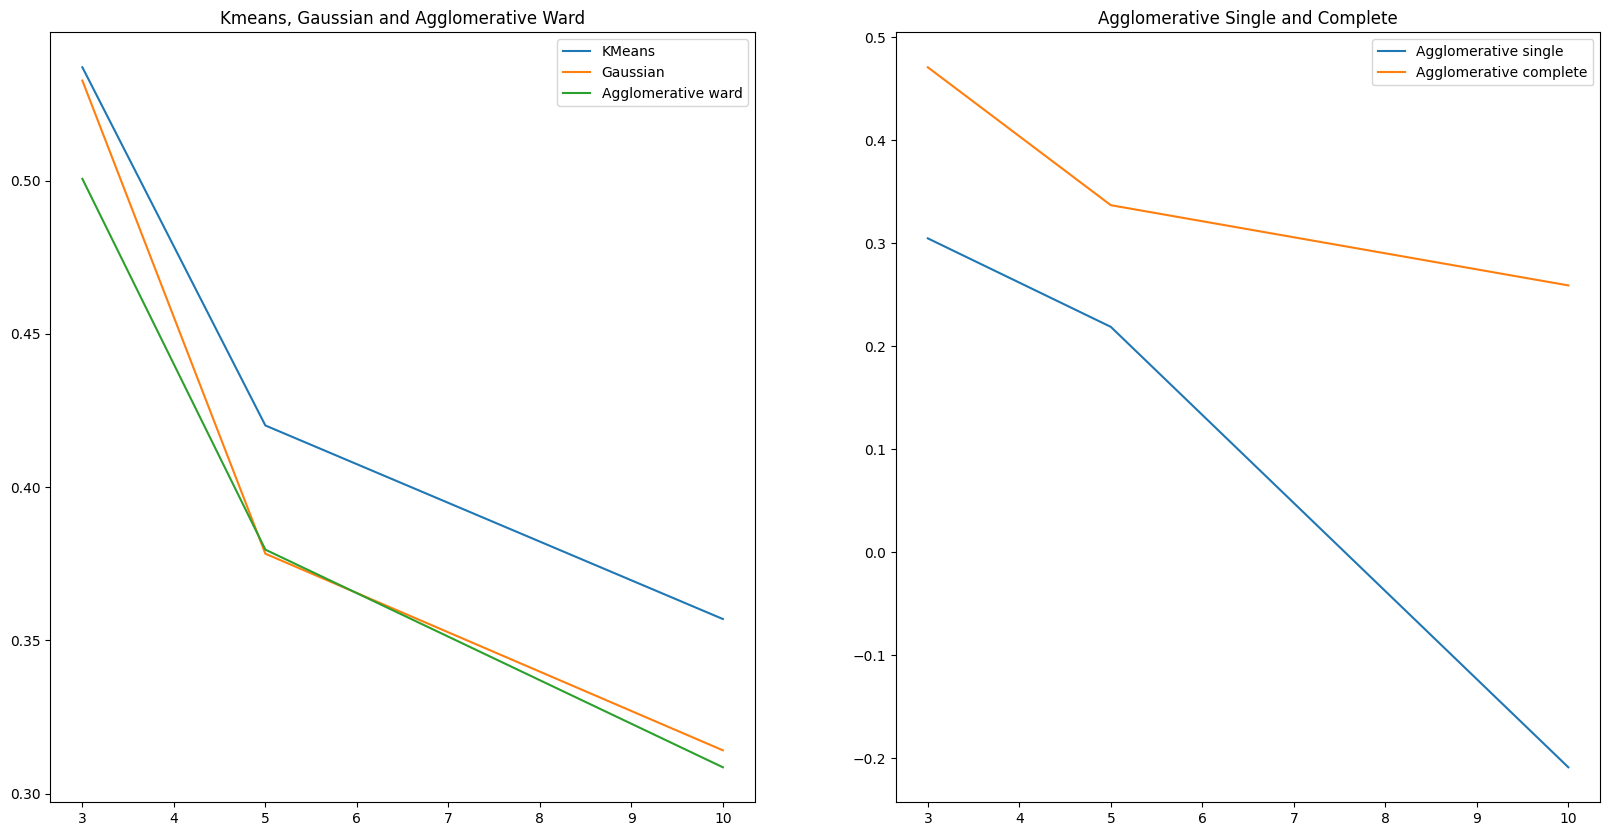

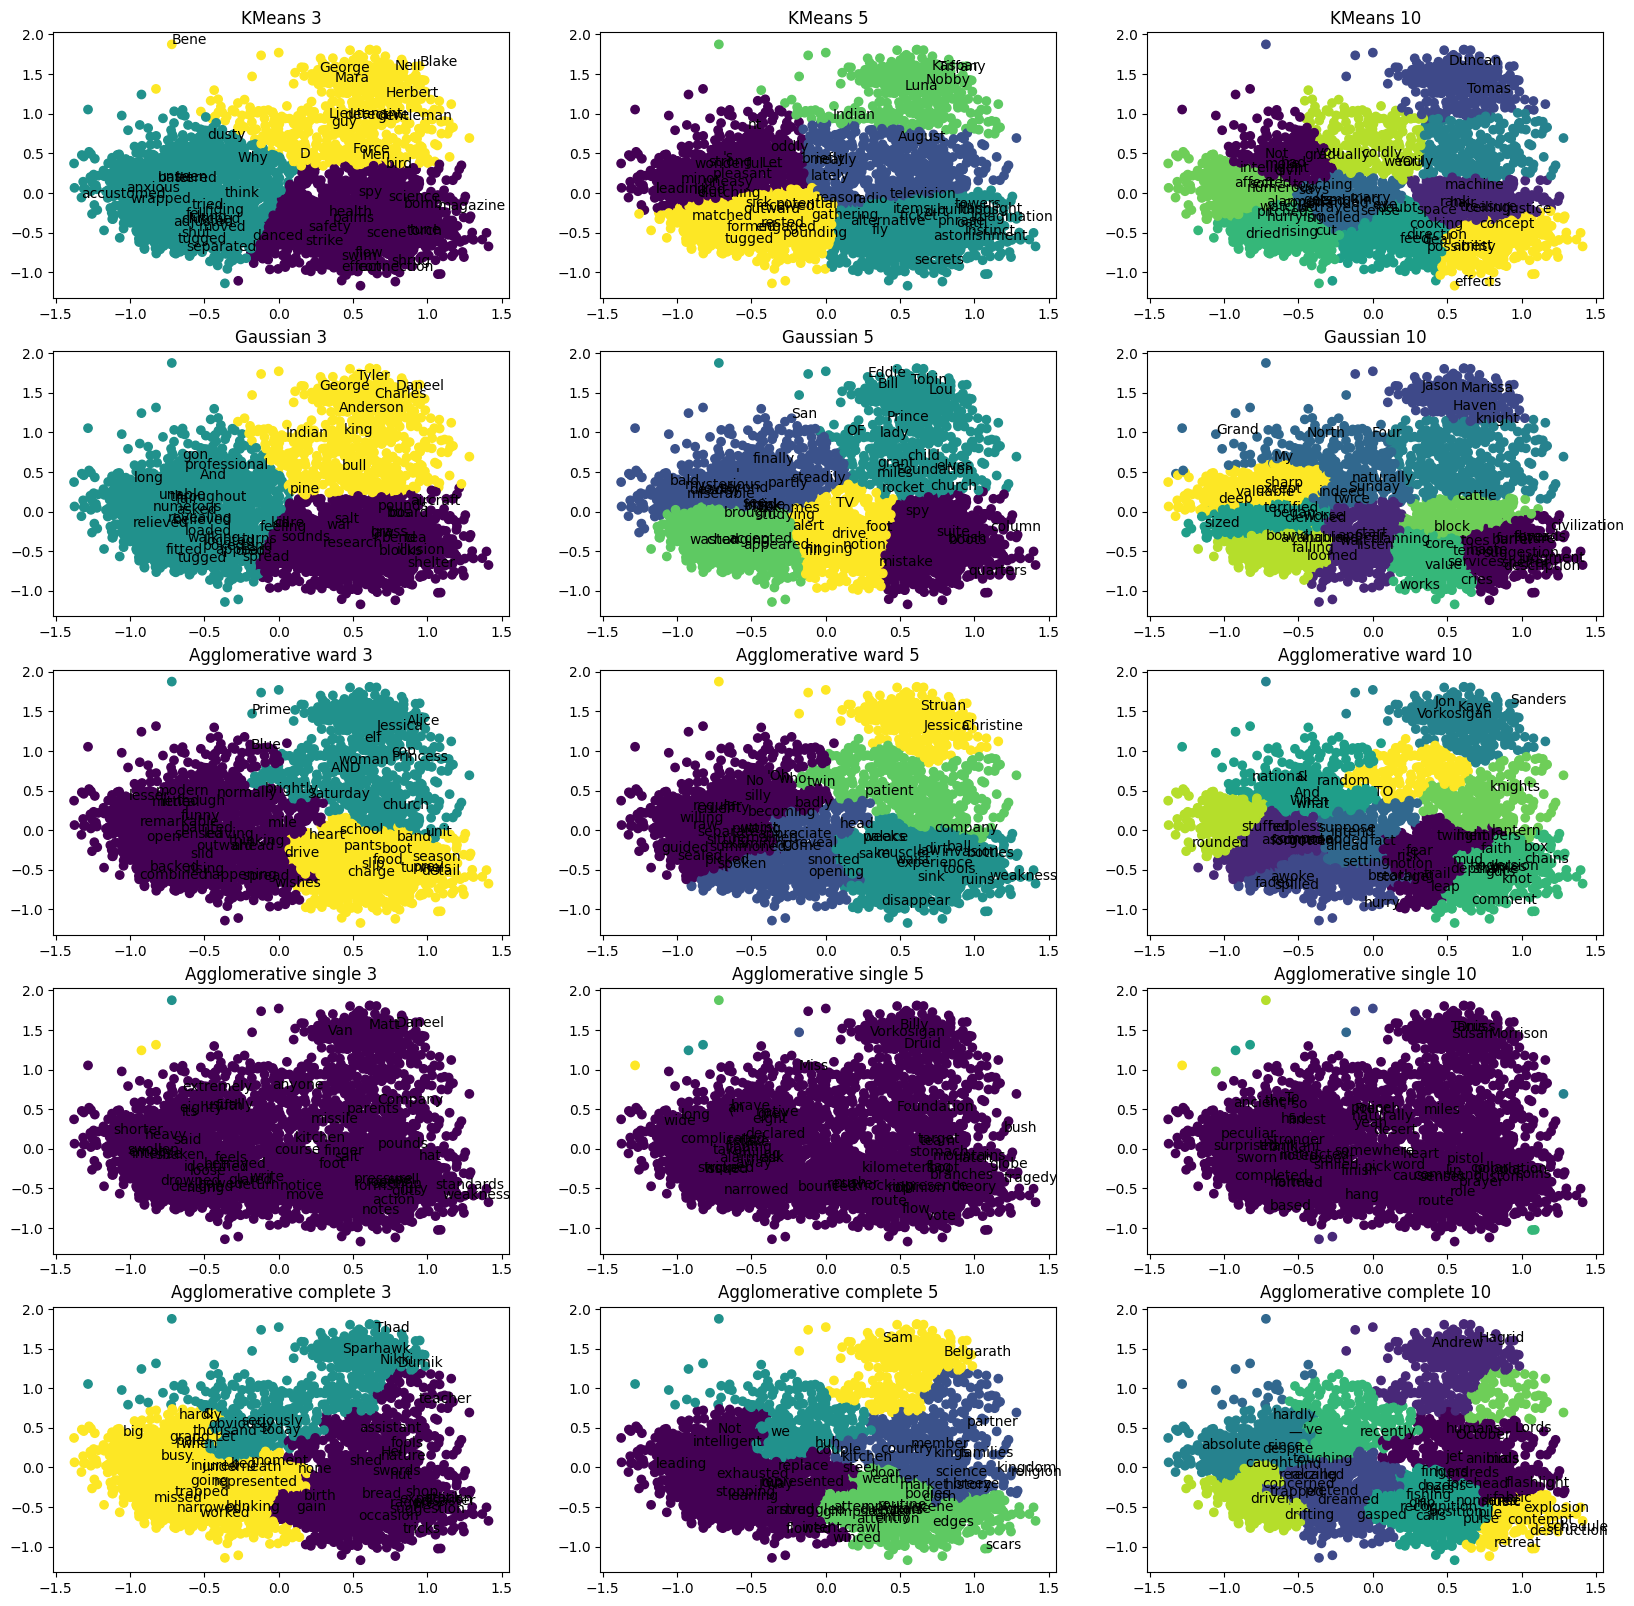

In [110]:
#compare for the same parameters as before
compare_silhouette_scores(Y_pca, t_sne=False)

Let's find the best number of clusters

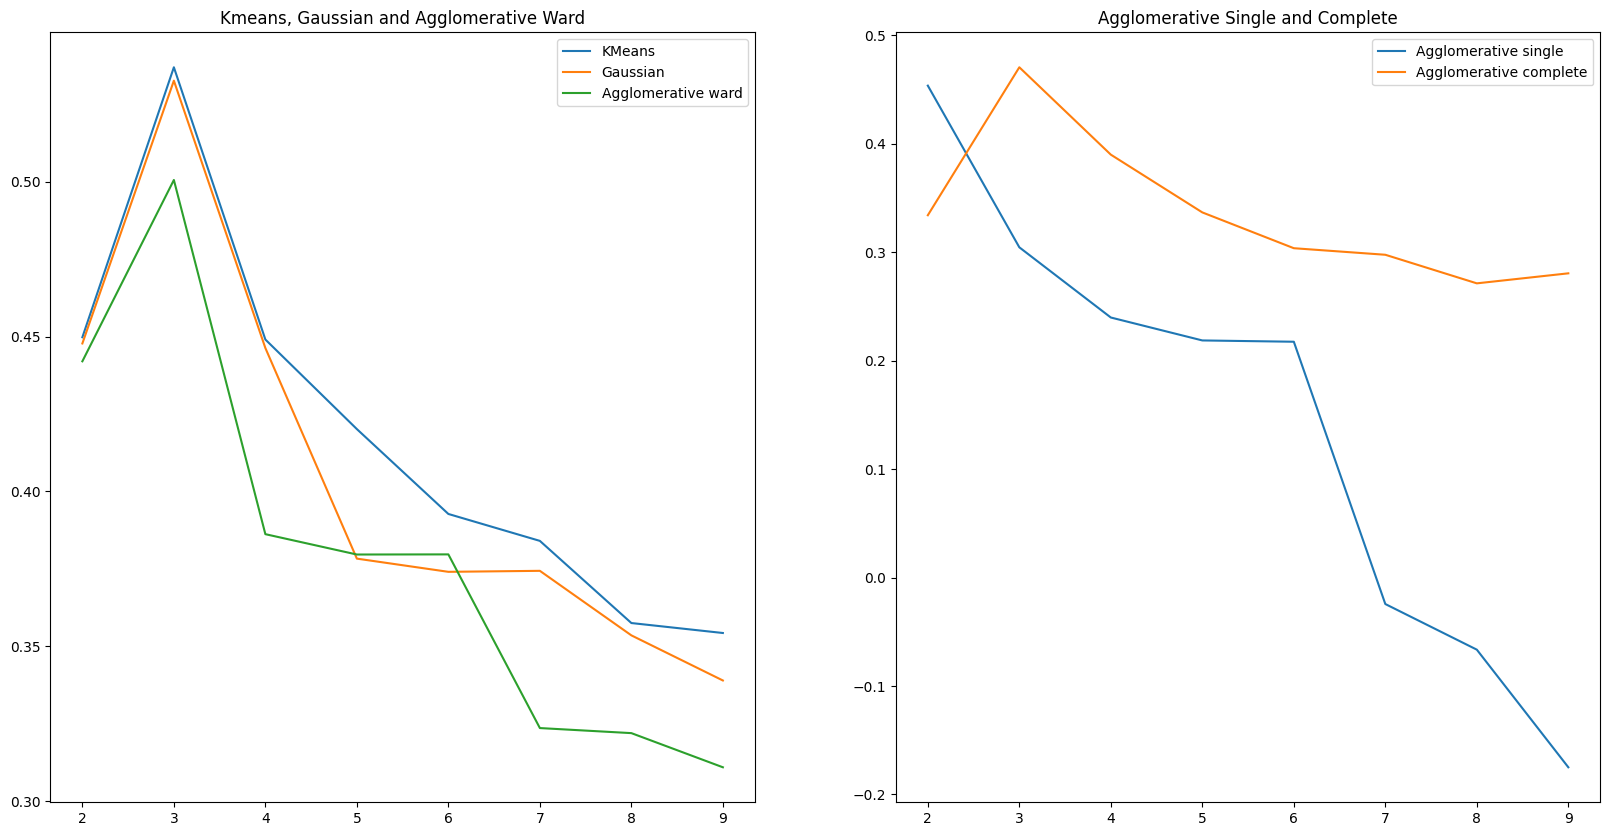

In [114]:
#compare for more clusters number so that we find the optimal number of clusters
n_clusters = np.arange(2, 10)
compare_silhouette_scores(Y_pca, n_clusters=n_clusters, t_sne=False, plot_clusters=False)

This time, using the 2 PCA Components, the agglomerative complete method worked and we can see that the optimal number of clusters should be 3. The silhouette coefficients are so different because we got from 512 dimensions to only a few thanks to the PCA.

## Task 4

In [141]:
def visualize_PCA_components(vectors, words, n_bins=100, n_components=5):
    pca = PCA(n_components=n_components, random_state=0)
    Y = pca.fit_transform(vectors)
    fig, axs = plt.subplots(n_components, 1, figsize=(20, 40))
    #plot the distribution of each component with the words as label written in vertical
    for i in range(n_components):
        frequency, intervals = np.histogram(Y[:, i], bins=n_bins)
        #find a word for each bin
        words_bins = []
        for j in range(n_bins):
            #find the indices of the words that are in the interval
            indices = np.where((Y[:, i] >= intervals[j]) & (Y[:, i] < intervals[j+1]))[0]
            #find the word that is closest to the mean of the interval
            if len(indices) > 0:
                words_bins.append(words[indices[np.argmin(np.abs(Y[indices, i] - np.mean(Y[indices, i])))]])
            else:
                words_bins.append('')
        axs[i].bar(range(n_bins), frequency)
        axs[i].set_xticks(range(n_bins))
        axs[i].set_xticklabels(words_bins, rotation='vertical')
        axs[i].set_title('PCA Component {}'.format(i))
    plt.show()

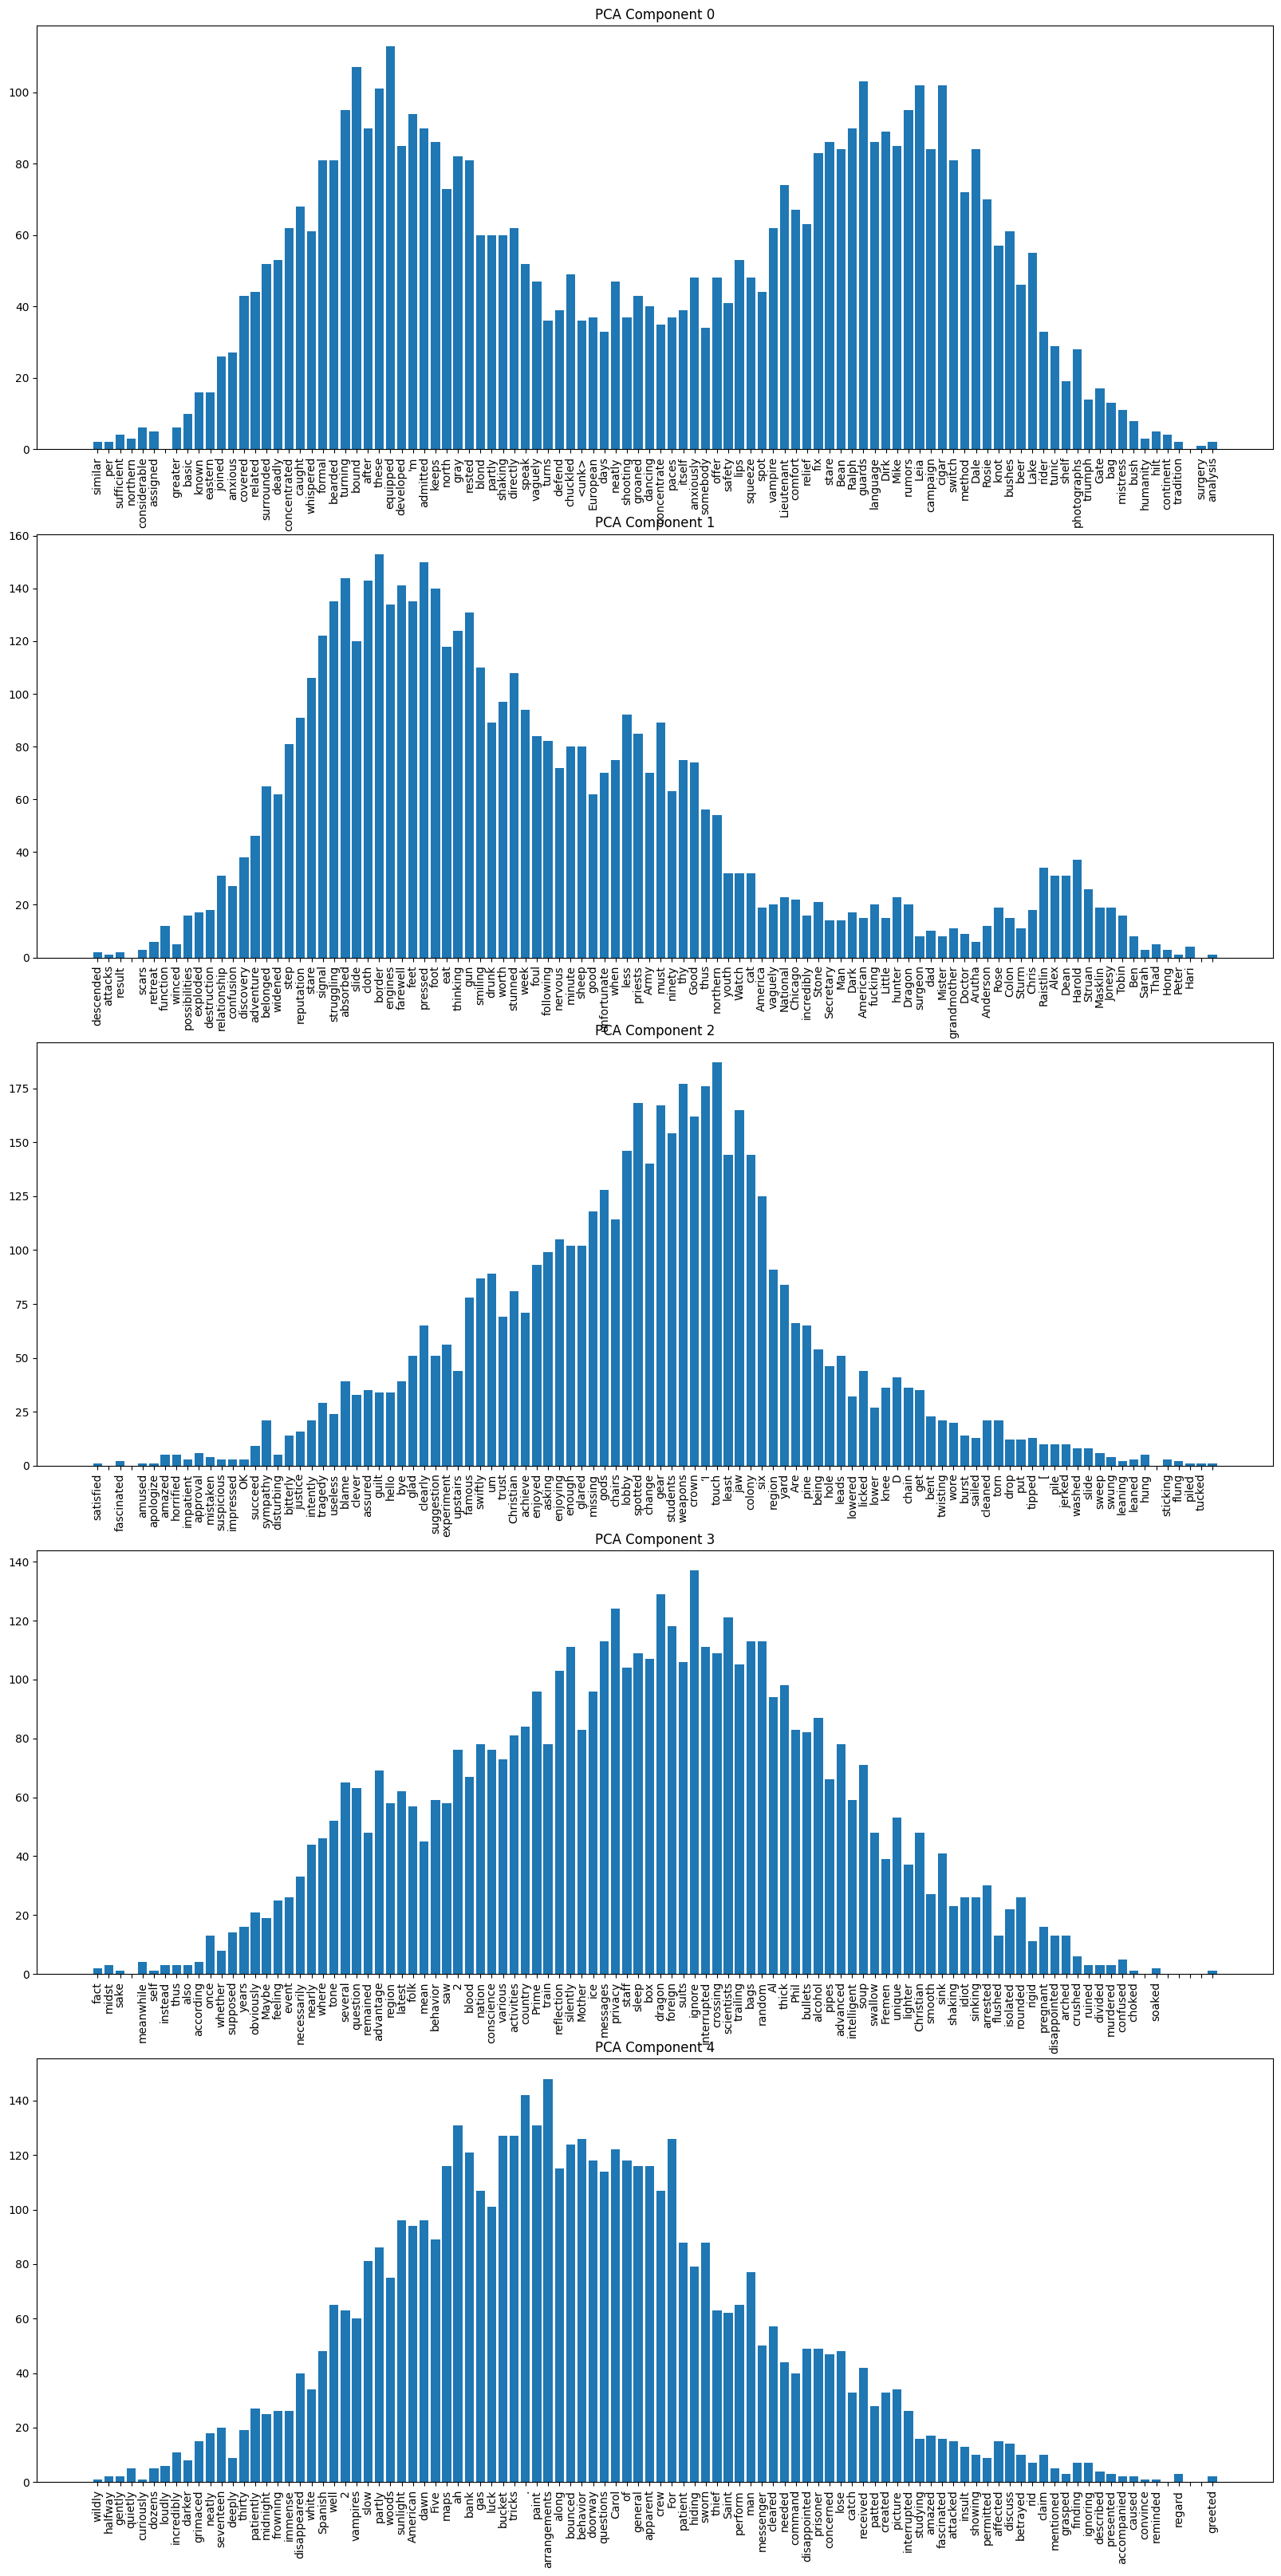

In [142]:
visualize_PCA_components(vectors, words)

Explaining features, let's focus on the edges :

1st : nothing in particular, it just seems that this component is trying to divide nouns and non-nouns

2nd : this component tells us if the word is a name or not

3rd : I think this component tells us if the word is a mental state (low values) or physical state (high values)

4th : This one gives high values to really bad thing happening (it is funny that we see pregnant there ahah)

5th : This one assigns high values to words corresponding to interactions

## Task 5

In [147]:
def visualize_ICA(vectors, words, n_components=50, n_visualize = 5):
    ica = FastICA(n_components=n_components, random_state=0)
    Y = ica.fit_transform(vectors)
    fig, axs = plt.subplots(n_visualize, 1, figsize=(20, 40))
    #plot the distribution of each component with the words as label written in vertical
    for i in range(n_visualize):
        frequency, intervals = np.histogram(Y[:, i], bins=100)
        #find a word for each bin
        words_bins = []
        for j in range(100):
            #find the indices of the words that are in the interval
            indices = np.where((Y[:, i] >= intervals[j]) & (Y[:, i] < intervals[j+1]))[0]
            #find the word that is closest to the mean of the interval
            if len(indices) > 0:
                words_bins.append(words[indices[np.argmin(np.abs(Y[indices, i] - np.mean(Y[indices, i])))]])
            else:
                words_bins.append('')
        axs[i].bar(range(100), frequency)
        axs[i].set_xticks(range(100))
        axs[i].set_xticklabels(words_bins, rotation='vertical')
        axs[i].set_title('ICA Component {}'.format(i))
    plt.show()

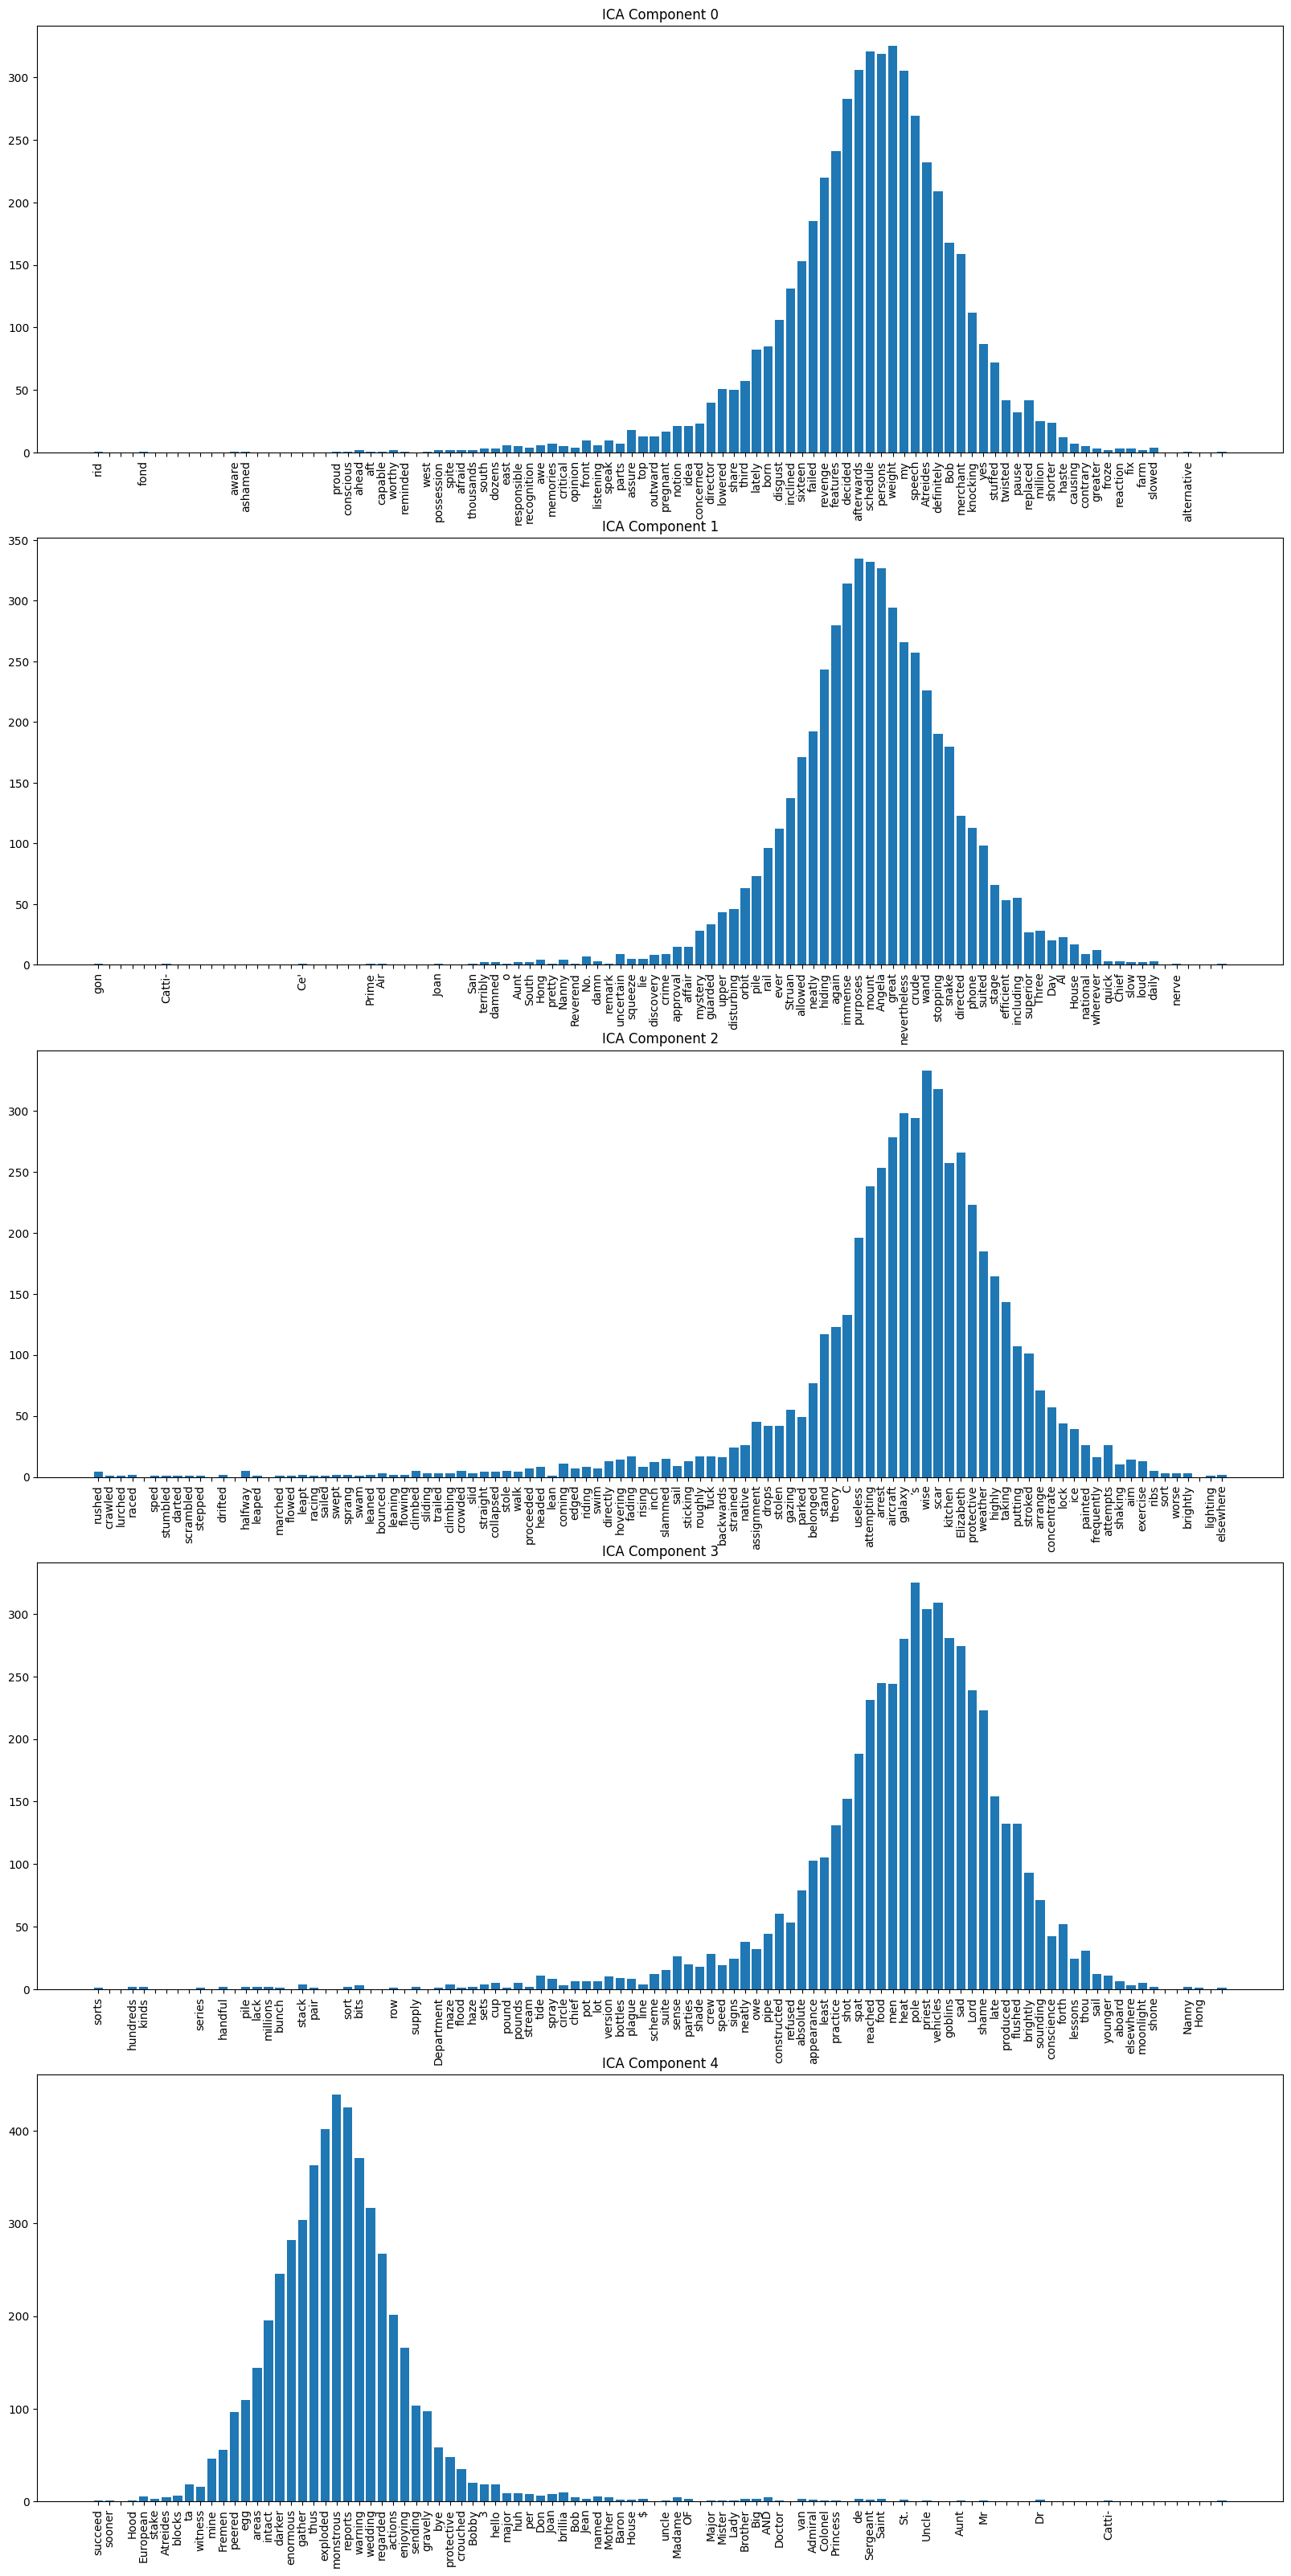

In [149]:
visualize_ICA(vectors, words)

All these components seems gaussians, let's try to analyze what are they representing the same way as before, this time focusing on the middle of the gaussian distribution :

1st : nothing in particular, it just seems that this component is trying to represents nouns again

2nd : this one feels like adventure (mount, immense, purposes, snake ...)

3rd : I am really not sure about this one but as we see Elizabeth maybe some royal stuff, there is also space related words, aircraft, attempting etc.. so maybe space projects ?

4th : This components might have something to do with religion (priest, lord) or fantasy (goblins) but it is hard to know

5th : This one represents scary, dangerous or even preventive words
